In [14]:
import matplotlib.pyplot as plt
import httpx  # install via pip install httpx
import csv
import pandas as pd

BASE_URL = "http://127.0.0.1:25510/v2"  # all endpoints use this URL base

# set params
params = {
  'root': 'AAPL',
  'start_date': '20241107',
  'end_date': '20241114',
  'use_csv': 'true',
  'ivl': '0',
}
#
# This is the non-streaming version, and the entire response
# will be held in memory.
#
url = BASE_URL + '/hist/stock/quote'

df = pd.DataFrame()
first_page = True
cols = None

while url is not None:
    response = httpx.get(url, params=params, timeout=60)  # make the request
    response.raise_for_status()  # make sure the request worked

    # read the entire response, and parse it as CSV
    csv_reader = csv.reader(response.text.split("\n"))
    
    if first_page:
        cols = next(csv_reader)
        df = pd.concat([df, pd.DataFrame(columns=cols)])
        first_page = False
    
    df = pd.concat([df, pd.DataFrame(csv_reader, columns=cols)])

    # check the Next-Page header to see if we have more data
    if 'Next-Page' in response.headers and response.headers['Next-Page'] != "null":
        url = response.headers['Next-Page']
        params = None
    else:
        url = None


stock_v1 = df
stock_v1['ask'] = pd.to_numeric(stock_v1['ask'], errors='coerce')
stock_v1['bid'] = pd.to_numeric(stock_v1['bid'], errors='coerce')

stock_v1 = stock_v1.loc[pd.to_numeric(stock_v1['ms_of_day'], errors='coerce').notnull()]
stock_v1 = stock_v1.loc[(stock_v1['ask'] != 0) & (stock_v1['bid'] != 0)]

grouped_stock_v1 = stock_v1.groupby('ms_of_day').last()
grouped_stock_v1['bid'] = grouped_stock_v1['bid'].astype(float)
grouped_stock_v1['ask'] = grouped_stock_v1['ask'].astype(float)
grouped_stock_v1['price'] = (grouped_stock_v1['bid'] + grouped_stock_v1['ask']) / 2
grouped_stock_v1.index = pd.to_datetime(grouped_stock_v1.index, unit='ms')

grouped_stock_v1

/var/folders/1g/l8bcpmkn2hs1dx91vyw0c7pc0000gn/T/ipykernel_29782/3229412054.py:59: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  grouped_stock_v1.index = pd.to_datetime(grouped_stock_v1.index, unit='ms')


,bid_size,bid_exchange,bid,bid_condition,ask_size,ask_exchange,ask,ask_condition,date,price
ms_of_day,,,,,,,,,,
1970-01-01 04:00:00.004,2,65,223.77,0,2,65,225.40,0,20241114,224.585
1970-01-01 04:00:00.005,2,65,223.77,0,2,65,225.40,0,20241114,224.585
1970-01-01 04:00:00.006,1,65,224.23,0,2,65,225.40,0,20241114,224.815
1970-01-01 04:00:00.007,1,65,224.23,0,1,65,225.40,0,20241114,224.815
1970-01-01 04:00:00.010,1,65,224.23,0,1,65,225.39,0,20241114,224.810
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 19:59:57.714,1,7,227.65,0,1,60,227.70,0,20241107,227.675
1970-01-01 19:59:59.148,1,7,224.70,0,1,65,224.91,0,20241113,224.805
1970-01-01 19:59:59.216,1,1,223.66,0,2,7,223.95,0,20241111,223.805


In [16]:
df = grouped_stock_v1

ms_of_day
1970-01-01 04:00:00    224.871766
1970-01-01 04:01:40    224.963293
1970-01-01 04:03:20    224.743627
1970-01-01 04:05:00    224.678075
1970-01-01 04:06:40    224.578276
                          ...    
1970-01-01 19:51:40    226.048750
1970-01-01 19:53:20    225.127628
1970-01-01 19:55:00    225.517214
1970-01-01 19:56:40    225.526368
1970-01-01 19:58:20    225.313591
Freq: 100s, Name: price, Length: 576, dtype: float64

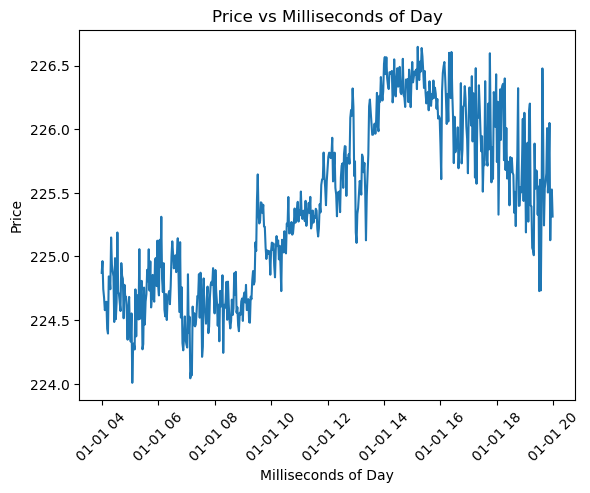

In [18]:

def plot_resampled_price(data, resample_interval='100s'):
    grouped_stock_v1_resampled = grouped_stock_v1['price'].resample('100s').mean()
    display(grouped_stock_v1_resampled)
    plt.plot(grouped_stock_v1_resampled.index, grouped_stock_v1_resampled)
    plt.xlabel('Milliseconds of Day')
    plt.ylabel('Price')
    plt.title('Price vs Milliseconds of Day')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

plot_resampled_price(df, resample_interval='100s')

In [19]:
four_oclock_ms = 4 * 60 * 60 * 1000  # 4 o'clock in milliseconds
grouped_stock_v1.index = grouped_stock_v1.index.astype('int64') // 1_000_000  # Convert datetime to milliseconds
grouped_stock_v1.index = grouped_stock_v1.index - four_oclock_ms
grouped_stock_v1

,bid_size,bid_exchange,bid,bid_condition,ask_size,ask_exchange,ask,ask_condition,date,price
ms_of_day,,,,,,,,,,
4,2,65,223.77,0,2,65,225.40,0,20241114,224.585
5,2,65,223.77,0,2,65,225.40,0,20241114,224.585
6,1,65,224.23,0,2,65,225.40,0,20241114,224.815
7,1,65,224.23,0,1,65,225.40,0,20241114,224.815
10,1,65,224.23,0,1,65,225.39,0,20241114,224.810
...,...,...,...,...,...,...,...,...,...,...
57597714,1,7,227.65,0,1,60,227.70,0,20241107,227.675
57599148,1,7,224.70,0,1,65,224.91,0,20241113,224.805
57599216,1,1,223.66,0,2,7,223.95,0,20241111,223.805


In [20]:
stock_output = grouped_stock_v1[['date', 'price']]
stock_output.to_csv('stock_output.csv')

In [21]:
data = pd.read_csv('stock_output.csv')
data[['price']].to_csv('us_data.csv')